<a href="https://colab.research.google.com/github/Sharath2021/-LIVE-CLASS-MONITORING-SYSTEM-Face-Emotion-Recognition-/blob/main/LIVE_CLASS_MONITORING_SYSTEM(Face_Emotion_Recognition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Importing libraries

import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [2]:
# to not get tensed over unnecessary warning we will ignore them
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading zip file

from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/archive .zip'

In [8]:
# Extracting zip file

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [9]:
#test and train data
test_data = '/content/test/'
train_data = '/content/train/'

In [11]:
#list the directory of test data
os.listdir(test_data)

['happy', 'angry', 'neutral', 'sad', 'disgust', 'surprise', 'fear']

In [12]:
#list the directory of train data
os.listdir(train_data)

['happy', 'angry', 'neutral', 'sad', 'disgust', 'surprise', 'fear']

In [25]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.data.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_data in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_data)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

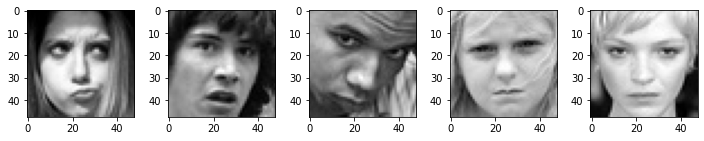

In [16]:
#sample images of angry class
plot_images(train_data+'/angry')

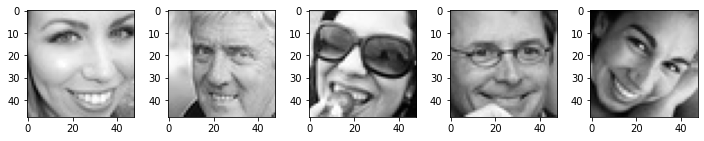

In [17]:
#sample of happy class
plot_images(train_data+'/happy')

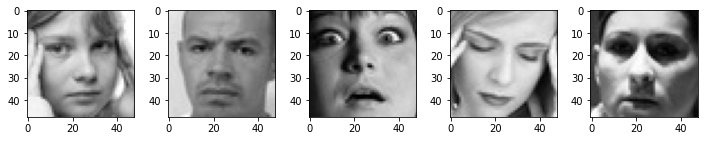

In [19]:
#sample of fear class
plot_images(train_data+'/fear')

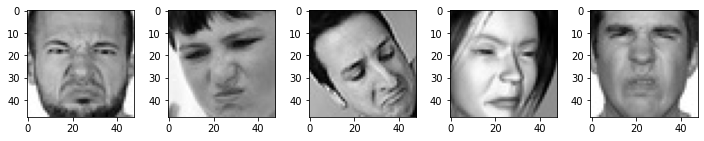

In [20]:
#sample images of disgust class
plot_images(train_data+'/disgust')

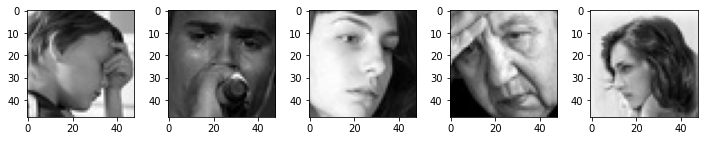

In [21]:
#sample of sad class
plot_images(train_data+'/sad')

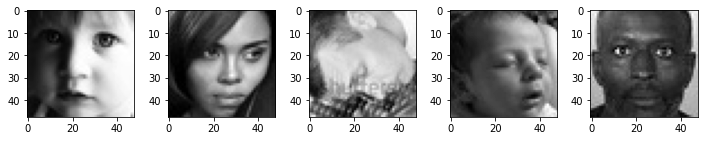

In [22]:
#sample of neutral class
plot_images(train_data+'/neutral')

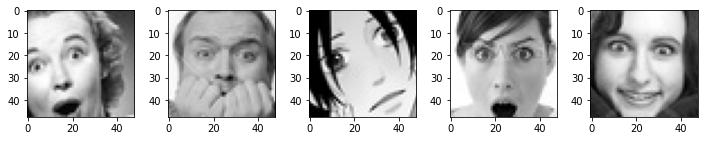

In [23]:
#sample of surprise class
plot_images(train_data+'/surprise')

In [26]:
# lenght of images in each class

list_dir_train = os.listdir(train_data)
for expression in list_dir_train:
    print(str(len(os.listdir(train_data + expression))) + " " + expression + " images")

7215 happy images
3995 angry images
4965 neutral images
4830 sad images
436 disgust images
3171 surprise images
4097 fear images


In [27]:
img_size = 48
batch_size = 32

# selecting colour mode as rgb as resnet is trained on rgb photos and we have grascaled images
training_datagen = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
train_generator = training_datagen.flow_from_directory(train_data,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

datagen_validation = ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
validation_generator = training_datagen.flow_from_directory(test_data,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [28]:
# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [31]:
# Creating  Training Dataset

train_gen=training_gen.flow_from_directory(train_data,                
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set

test_gen=testing_gen.flow_from_directory(test_data,                                       
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [32]:
#printing the class indices of train_gen
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [33]:
# from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(no_of_classes, activation='softmax'))
opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [34]:
# Adding various Callbacks Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')          

#early stopping

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks=[early_stopping,checkpoint,decay_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [35]:
#fitting the generator

results = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=40,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks
                                )

Epoch 1/40
897/897 [==============================] - 48s 40ms/step - loss: 1.7009 - accuracy: 0.3488 - val_loss: 1.4181 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 2/40
897/897 [==============================] - 35s 40ms/step - loss: 1.3595 - accuracy: 0.4735 - val_loss: 1.3012 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 3/40
897/897 [==============================] - 35s 39ms/step - loss: 1.2472 - accuracy: 0.5256 - val_loss: 1.2523 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 4/40
897/897 [==============================] - 35s 39ms/step - loss: 1.1761 - accuracy: 0.5540 - val_loss: 1.2382 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 5/40
897/897 [==============================] - 35s 39ms/step - loss: 1.1246 - accuracy: 0.5767 - val_loss: 1.2613 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 6/40
897/897 [==============================] - 35s 39ms/step - loss: 1.0767 - accuracy: 0.5921 - val_loss: 1.2805 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 7/40
897/897 [==============================] - 35s 

In [39]:
# Predicting Test Set
predictions=model.predict(test_gen)

# Printing Confution Matrix
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                                  


In [41]:
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/CNN_model.h5')

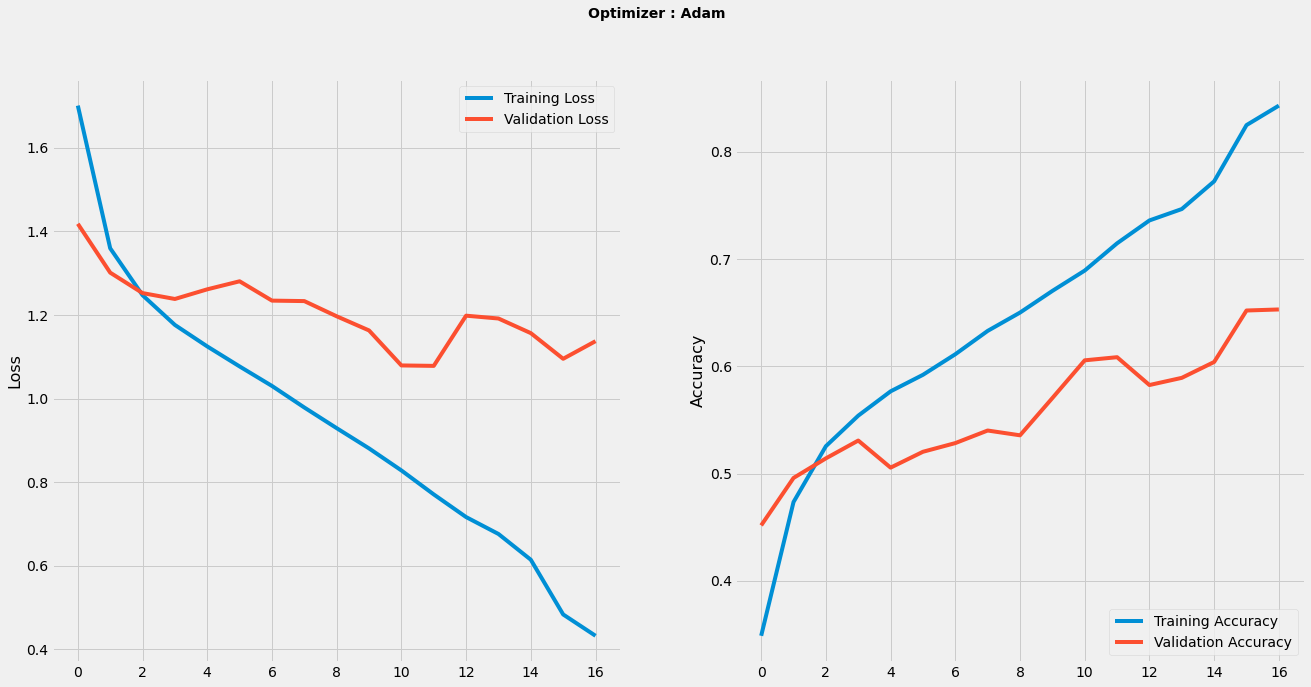

In [42]:
#Plot to describe Accuracy & Loss
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=14,fontweight = 'bold')
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()